In [103]:
import pandas as pd
import subprocess
from Bio import Entrez, SeqIO
import ast
import os
import numpy as np

In [6]:
dfc=pd.read_csv("revised_cluster_info_v3.csv",index_col=0)

In [7]:
dfc=dfc[dfc.n_species>1]

## Run PAML for dn/ds for all chimeras in >1 species

Prep: fasta downloads for all secondary chimeras, concatenation, MSA generation and tree inference

In [ ]:
for c in dfc[dfc.n_species>1].sort_values("n_species").index:
    if c not in os.listdir("dnds"):
        print(c)
        subprocess.run(["mkdir", f"dnds/{c}"])
        #download protein and nucleotide fastas 
        sec_chimeras=ast.literal_eval(dfc.loc[c,:].secondary_chimeras)
        for acc in sec_chimeras:
            subprocess.run(["mkdir", f"dnds/{c}/{acc}"])
            url_na=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={acc}&rettype=fasta_cds_na" 
            url_prot=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={acc}&rettype=fasta" 
            subprocess.run(["wget",url_na,"-O",f"dnds/{c}/{acc}/nuc.fasta"])
            subprocess.run(["wget",url_prot,"-O",f"dnds/{c}/{acc}/prot.fasta"])

        main_directory =f"dnds/{c}"

        # Create an output file for concatenated sequences
        output_nuc = f"dnds/{c}/concatenated_nuc.fasta"
        output_prot = f"dnds/{c}/concatenated_prot.fasta"

        # Initialize an empty list to store sequences
        all_nucs = []
        all_prots = []

        # Iterate through subdirectories and create a list of all fastas
        #Written by RK w/ ChatGPT
        for subdir in os.listdir(main_directory):
            subdirectory_path = os.path.join(main_directory, subdir)

            if os.path.isdir(subdirectory_path):
                nuc_fasta_file = os.path.join(subdirectory_path, "nuc.fasta")
                prot_fasta_file = os.path.join(subdirectory_path, "prot.fasta")
                if os.path.exists(nuc_fasta_file):
                    # Read the sequences from nuc.fasta and add to the list
                    sequences = list(SeqIO.parse(nuc_fasta_file, "fasta"))
                    all_nucs.extend(sequences)

                if os.path.exists(prot_fasta_file):
                    # Read the sequences from nuc.fasta and add to the list
                    sequences = list(SeqIO.parse(prot_fasta_file, "fasta"))
                    all_prots.extend(sequences)

        # Write the concatenated sequences to the output file
        with open(output_nuc, "w") as output_handle:
            SeqIO.write(all_nucs, output_handle, "fasta")

        with open(output_prot, "w") as output_handle:
            SeqIO.write(all_prots, output_handle, "fasta")
        
        
        input_file = open(f"dnds/{c}/concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        input_file = open(f"dnds/{c}/concatenated_nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        
        f=open(f"dnds/{c}/concatenated_nuc.fasta","w")
        f1=open(f"dnds/{c}/concatenated_prot.fasta","w")
        for p in prot_dict.keys():
            kn=[x for x in nuc_dict.keys() if p in x]
            if len(kn)>0:
                kn=kn[0]
                f.write(f">{kn}")
                f.write("\n")
                f.write(str(nuc_dict[kn].seq))
                f.write("\n")

                f1.write(f">{p}")
                f1.write("\n")
                f1.write(str(prot_dict[p].seq))
                f1.write("\n")
        f.close()
        f1.close()
        
        if int(dfc.loc[c,"n_species"])==2:
            print("Concatenation complete.")
            f=open(f"dnds/{c}/tree.newick","w")
            f.write("(")
            f.write(str(all_prots[0].name))
            f.write(":1,")
            f.write(str(all_prots[1].name))
            f.write(":1")
            f.write(");")
            f.close()
            subprocess.run(["sh","dnds_scripts/run_muscle.sh", str(c)])
        else:
            subprocess.run(["sbatch","dnds_scripts/run_iqtree_pipe.sh", str(c)])
            
  
   
 



XP_033212670.1


URL transformed to HTTPS due to an HSTS policy
--2023-09-06 15:51:27--  https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id=CAD6241409.1&rettype=fasta_cds_na
Resolving eutils.ncbi.nlm.nih.gov... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to eutils.ncbi.nlm.nih.gov|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘dnds/XP_033212670.1/CAD6241409.1/nuc.fasta’

     0K ......                                                 93.6M=0s

2023-09-06 15:51:28 (93.6 MB/s) - ‘dnds/XP_033212670.1/CAD6241409.1/nuc.fasta’ saved [6271]

URL transformed to HTTPS due to an HSTS policy
--2023-09-06 15:51:29--  https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id=CAD6241409.1&rettype=fasta
Resolving eutils.ncbi.nlm.nih.gov... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to eutils.ncbi.nlm.nih.gov|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

# Producing codon alignments and running PAML M0 model fitting

In [14]:
for c in dfc[dfc.n_species>1].sort_values("n_species").index:
    if "paml_output.out" not in os.listdir(f"dnds/{c}"):
        print(c,dfc.loc[c,"n_species"])
        input_file = open(f"dnds/{c}/MSA_concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        input_file = open(f"dnds/{c}/concatenated_nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        #make sure msa and nucleotide fasta are in the same order 
        f=open(f"dnds/{c}/concatenated_nuc.fasta","w")
        f1=open(f"dnds/{c}/MSA_concatenated_prot.fasta","w")
        for p in prot_dict.keys():
            kn=[x for x in nuc_dict.keys() if p in x]
            if len(kn)>0:
                kn=kn[0]
                f.write(f">{kn}")
                f.write("\n")
                f.write(str(nuc_dict[kn].seq))
                f.write("\n")

                f1.write(f">{p}")
                f1.write("\n")
                f1.write(str(prot_dict[p].seq))
                f1.write("\n")
        f.close()
        f1.close()
        #produce a gapless codon alignment guided by the MSA 
        subprocess.run(["sh","dnds_scripts/run_pal2nal.sh", "dnds",str(c)])
        #run codeml to get gene-wide dn/ds value
        subprocess.run(["sbatch","dnds_scripts/run_paml_m0.sh", str(c)])

XP_029662819.1 368.0


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


Submitted batch job 1997305


Rerunning M0 with dn/ds fixed at 1 (neutral)

In [ ]:
for c in dfc[dfc.n_species>1].sort_values("n_species").index:
    subprocess.run(["sbatch","dnds_scripts/run_fixed_paml_whole_gene.sh", str(c)])

## Producing a summary table of dn/ds values and running an LRT (dn/ds<1)

In [8]:
dnds_data=pd.DataFrame(index=dfc[dfc.n_species>1].sort_values("n_species").representative_seq, columns=["dnds_f","lnL_f","np_f","dS_f","lnL_1","np_1"]) 

In [9]:
import numpy as np
import scipy 
from scipy import stats

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
gene_dnds={}
fails=[]
for c in dfc[dfc.n_species>1].sort_values("n_species").representative_seq:
    
    
    if "paml_output.out" in os.listdir(f"dnds/{c}") and "tree.newick" in os.listdir(f"dnds/{c}"):
       
        f=open(f"dnds/{c}/paml_output.out","r").readlines()
        t=False
        for i  in range(len(f)):
            x=f[i]
            if "omega (dN/dS) =" in x:
                dnds_data.loc[c,"dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
                
                t=True
            if "lnL(" in x:
                dnds_data.loc[c,"np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                dnds_data.loc[c,"lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
            if "tree length for dS:" in x:
                dnds_data.loc[c,"dS_f"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
            if "Printing out site pattern counts" in x:
            
                dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3
        if t==False:
            fails.append(c)
    else:
        print("no_paml"+c)
        fails.append(c)
       

In [15]:

for c in dfc[dfc.n_species>1].sort_values("n_species").representative_seq:
    
    
    if "fix_omega_paml_output.out" in os.listdir(f"dnds/{c}") and "tree.newick" in os.listdir(f"dnds/{c}"):
       
        f=open(f"dnds/{c}/fix_omega_paml_output.out","r").readlines()
        t=False
        for x in f:
           
            if "lnL(" in x:
                dnds_data.loc[c,"np_1"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                dnds_data.loc[c,"lnL_1"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
            
        if t==False:
            fails.append(c)
    else:
        print("no_paml"+c)
        fails.append(c)
       

In [17]:
dnds_data["delta_p"]=np.array(dnds_data["np_f"])-np.array(dnds_data["np_1"])
dnds_data["2*delta_L"]=2*(np.array(dnds_data["lnL_f"])-np.array(dnds_data["lnL_1"]))
# rum likelihood ratio test comparing dnds to dnds fixed at 1 
for index, row in dnds_data.iterrows():
    dnds_data.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2*delta_L"],row["delta_p"])

In [18]:
from statsmodels.stats.multitest import multipletests

# Example p-values
p_values = dnds_data.p_val.iloc[0:-1]

# Perform Benjamini-Hochberg correction
corrected_p_values =list( multipletests(p_values, method='fdr_bh')[1])
corrected_p_values.append(np.nan)




In [19]:
dnds_data.loc[:,"p_val_corrected"]=corrected_p_values

In [20]:
dnds_data

,dnds_f,lnL_f,np_f,dS_f,lnL_1,np_1,n_codons,delta_p,2*delta_L,p_val,p_val_corrected
representative_seq,,,,,,,,,,,
XP_029821973.3,0.33971,-2896.683786,7,0.4,-2919.54979,6,196.0,1,45.732008,1.355890e-11,1.549589e-11
XP_046439036.1,0.36748,-3431.617749,7,0.0204,-3434.389367,6,85.0,1,5.543236,1.855225e-02,1.855225e-02
XP_021699539.1,0.30439,-7742.86807,7,1.0528,-7840.067198,6,563.0,1,194.398256,3.486125e-44,5.070727e-44
XP_049881676.1,0.00734,-2898.277154,7,126.5068,-2914.117364,6,319.0,1,31.68042,1.817453e-08,1.938617e-08
XP_027204138.1,0.00169,-5858.335847,7,152.7057,-6133.573558,6,413.0,1,550.475422,9.921255e-122,3.174802e-121
XP_035711638.1,0.02834,-8180.030814,7,35.4748,-8242.731855,6,756.0,1,125.402082,4.155993e-29,5.115069e-29
XP_023329593.1,0.00459,-4670.2091,7,135.6057,-4783.747655,6,437.0,1,227.07711,2.586983e-51,4.139172e-51
XP_041972388.1,0.08296,-9127.450001,8,4.0719,-9711.510462,7,708.0,1,1168.120922,5.171182e-256,4.136946e-255
XP_037790819.1,0.29018,-6420.677218,8,0.4281,-6507.937074,7,400.0,1,174.519712,7.622370e-40,1.016316e-39


In [67]:
dnds_data.to_csv("whole_gene_dnds.csv")

## Partition (Fixed-Site) Models

In [39]:
import ast

In [129]:
hgt_inters=[]
for index, row in dfc.iterrows():
    hgt_inters.extend(ast.literal_eval(row.HGT_intervals))
    

In [41]:
to_do=[]
for x in dfc[dfc.n_species>1].representative_seq:
    if "m2_paml_output.out" not in os.listdir(f"dnds/{x}"):
        to_do.append(x)

AttributeError: 'DataFrame' object has no attribute 'representative_seq'

In [20]:
file=open("partion_model_fail.txt","w")
for c in dfc[dfc.n_species>1].representative_seq:
    if "tree.newick" in os.listdir(f"dnds/{c}"):
        try:
            ##run pal2nal to get a codon alignment with both amino acids and codons (including gaps)
            subprocess.run(["sh","dnds_scripts/run_pal2nal_codon.sh", str(c)])
            lines=open(f"dnds/{c}/pal2nal.codon","r").readlines()

            lines=[x.replace("\n","") for x in lines]
            prot_al={}
            nuc_al={}
            for i in range(len(lines)-1):
                l=lines[i].split()
                if len(l)>1:
                    if len(l[0])>3:

                        key=l[0]
                        if key not in nuc_al:
                            nuc_al[key]=l[1:]
                        else:
                            tl=nuc_al[key]
                            tl.extend(l[1:])
                            nuc_al[key]=tl
                    elif len(l[0])==1:

                        key=lines[i+1].split()[0]
                        if key not in prot_al:
                            prot_al[key]=l[1:]
                        else:
                            tl=prot_al[key]
                            tl.extend(l[1:])
                            prot_al[key]=tl
            ##produce a list of indices in the gapless alignment from the residue position in the representative chimera
            pos_ch=[]
            ch_index=0
            for i in range(len(nuc_al[c])):
                if nuc_al[c][i]!='---':
                    ch_index+=1
                if len([gene for gene in nuc_al.keys() if nuc_al[gene][i]=="---" or nuc_al[gene][i]=="TAA" or nuc_al[gene][i]=="TAG" or nuc_al[gene][i]=="TGA"])==0:
                    pos_ch.append(ch_index)

            inters=[x for x in hgt_inters if c in x]
            
            #write a paml configuration with residues in the hgt interval(s) marked as site type '2'
            #other residues marked as site type '1'
            for inter in inters:
                if inter not in os.listdir(f"dnds/{c}"):
                    print(inter)
                    try:
                        subprocess.run(["rm","-r",f"dnds/{c}/{inter}"])
                    except:
                        p=1
                    try:
                        os.mkdir(f"dnds/{c}/{inter}")
                    except:
                        p=1
                    interi=ast.literal_eval(inter.split("_")[-1])

                    f=open(f"dnds/{c}/pal2nal.paml","r").readlines()
                    f1=open(f"dnds/{c}/{inter}/fs_pal2nal.paml","w")
                    f[0].replace("\n","G \n")
                    f1.write(f[0].replace("\n","G \n"))
                    f1.write("G2")
                    f1.write("\n")
                    flags=[str(int(x>=interi[0] and x<=interi[1])+1) for x in pos_ch]
                    f1.write("".join(flags))
                    f1.write("\n")
                    for x in f[1:]:
                        f1.write(x)
                    f1.close()
                    subprocess.run(["sbatch","dnds_scripts/run_partition_paml.sh",str(c),inter])
        except:
            file.write(c)
            file.write("\n")
file.close()



perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


GCF_010883055.1;XP_033212670.1;HGT_(19,106)


rm: cannot remove 'dnds/XP_033212670.1/GCF_010883055.1;XP_033212670.1;HGT_(19,106)': No such file or directory


Submitted batch job 1999128


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


GCF_003651465.1;XP_029662819.1;HGT_(20,127)


rm: cannot remove 'dnds/XP_029662819.1/GCF_003651465.1;XP_029662819.1;HGT_(20,127)': No such file or directory


Submitted batch job 1999136


In [131]:
pdnds=pd.DataFrame()

In [132]:
for c in dfc[dfc.n_species>1].representative_seq:
    inters=[x for x in hgt_inters if c in x]
    for inter in inters:
        try:
            lines=open(f"dnds/{c}/{inter}/fs_pal2nal.paml", "r").readlines()
            pdnds.loc[inter,"nsites_2"]=len([x for x in lines[2].strip() if x=='2'])
            pdnds.loc[inter,"nsites"]=len(lines[2].strip())
        except:
            p=1
        try:
            lines=open(f"dnds/{c}/{inter}/m2_paml_output.out", "r").readlines()
            for x in lines:
                if "omega (dN/dS) =" in x:
                    pdnds.loc[inter,"dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
                if "lnL(" in x:
                    pdnds.loc[inter,"np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                    pdnds.loc[inter,"lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        except:
            print(inter)
            
        try:
            lines=open(f"dnds/{c}/{inter}/m4_paml_output.out", "r").readlines()
            for x in lines:
                if "gene # 1: kappa =" in x:
                    pdnds.loc[inter,"dnds_1"]=ast.literal_eval(x.split("omega =")[1].strip())
                if "gene # 2: kappa =" in x:
                    pdnds.loc[inter,"dnds_2"]=ast.literal_eval(x.split("omega =")[1].strip())
                if "lnL(" in x:
                    pdnds.loc[inter,"np_p"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                    pdnds.loc[inter,"lnL_p"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
                
        except:
            print(inter)

GCF_024362695.1;XP_049881676.1;HGT_(1,78)
GCF_024362695.1;XP_049881676.1;HGT_(1,78)


In [133]:
pdnds["delta_p"]=np.array(pdnds["np_p"])-np.array(pdnds["np_f"])
pdnds["2*delta_L"]=2*(np.array(pdnds["lnL_p"])-np.array(pdnds["lnL_f"]))
for index, row in pdnds.iterrows():
    pdnds.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2*delta_L"],row["delta_p"])

In [134]:
pdnds=pdnds.dropna(axis=0)

In [119]:

p_values = pdnds.p_val

# Perform Benjamini-Hochberg correction
corrected_p_values = multipletests(p_values, method='fdr_bh')[1]

correct_p_values=list(corrected_p_values)
pdnds.loc[:,"correct_p_values"]=correct_p_values

In [120]:
pdnds['prot']=[x.split(";")[1].split(";")[0] for x in pdnds.index]
for index, row in pdnds.iterrows():
    pdnds.loc[index,'cluster']=dfc[dfc.representative_seq==row.prot].index.values[0]
    pdnds.loc[index,'interval']="'"+index.split("_")[-1]+"'"

In [121]:
pdnds=pdnds.set_index("prot")

In [122]:
pdnds.loc[:,['cluster', 'interval','nsites_2', 'nsites', 'np_f', 'lnL_f', 'dnds_f', 'np_p', 'lnL_p',
       'dnds_1', 'dnds_2', 'delta_p', '2*delta_L', 'p_val', 'correct_p_values']].to_csv("data_upload_3_24_2025/Supplementary Table XIII_ partition model dN_dS - partition model dnd_s.tsv")

In [123]:
pdnds.to_csv("data_upload_3_24_2025/Supplementary Table XIII_ partition model dN_dS - partition model dnd_s.tsv",sep="\t")

## Figure 5D-E

In [124]:
pdnds=pd.read_csv("data_upload_3_24_2025/Supplementary Table XIII_ partition model dN_dS - partition model dnd_s.tsv",sep="\t",index_col=0)

In [125]:
dnds_data=pd.read_csv("data_upload_3_24_2025/Supplementary Table XII_ gene-wide dN_dS - whole_gene_dnds.csv",index_col=0)

In [126]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['svg.fonttype']='none'

In [127]:
pdnds

,nsites_2,nsites,np_f,lnL_f,dnds_f,np_p,lnL_p,dnds_1,dnds_2,delta_p,2*delta_L,p_val,correct_p_values,cluster,interval
prot,,,,,,,,,,,,,,,
XP_034487048.1,42.0,117.0,304.0,-25145.328927,0.12936,306.0,-25138.698301,0.13653,0.11666,2.0,13.261252,1.319337e-03,7.476243e-03,1.0,"'(412,553)'"
XP_050528041.1,45.0,265.0,36.0,-6500.959093,0.19315,38.0,-6500.718382,0.19710,0.17131,2.0,0.481422,7.860688e-01,9.545121e-01,2.0,"'(34,150)'"
XP_035715507.1,108.0,185.0,22.0,-5717.872268,0.08405,24.0,-5717.578813,0.07845,0.09008,2.0,0.586910,7.456828e-01,9.545121e-01,3.0,"'(127,249)'"
XP_034827763.1,204.0,339.0,14.0,-5924.881911,0.08286,16.0,-5923.287863,0.07782,0.08704,2.0,3.188096,2.031018e-01,3.452730e-01,4.0,"'(34,408)'"
XP_044763649.1,549.0,682.0,12.0,-10823.828960,0.05449,14.0,-10819.344297,0.09268,0.04841,2.0,8.969326,1.128069e-02,3.835434e-02,5.0,"'(158,738)'"
XP_042220148.1,147.0,504.0,12.0,-7058.727976,0.26874,14.0,-7058.020573,0.28056,0.24234,2.0,1.414806,4.929227e-01,6.983071e-01,6.0,"'(352,559)'"
XP_046456339.1,199.0,1075.0,10.0,-15724.492356,0.35579,12.0,-15712.260435,0.38850,0.24113,2.0,24.463842,4.872414e-06,4.141552e-05,7.0,"'(49,253)'"
XP_046649021.1,183.0,640.0,8.0,-5435.336023,0.10409,10.0,-5416.746858,0.14252,0.04017,2.0,37.178330,8.449446e-09,1.436406e-07,8.0,"'(451,633)'"
XP_037790819.1,428.0,1020.0,6.0,-6508.883651,0.27660,8.0,-6505.233972,0.34231,0.20970,2.0,7.299358,2.599947e-02,7.366517e-02,9.0,"'(738,1165)'"


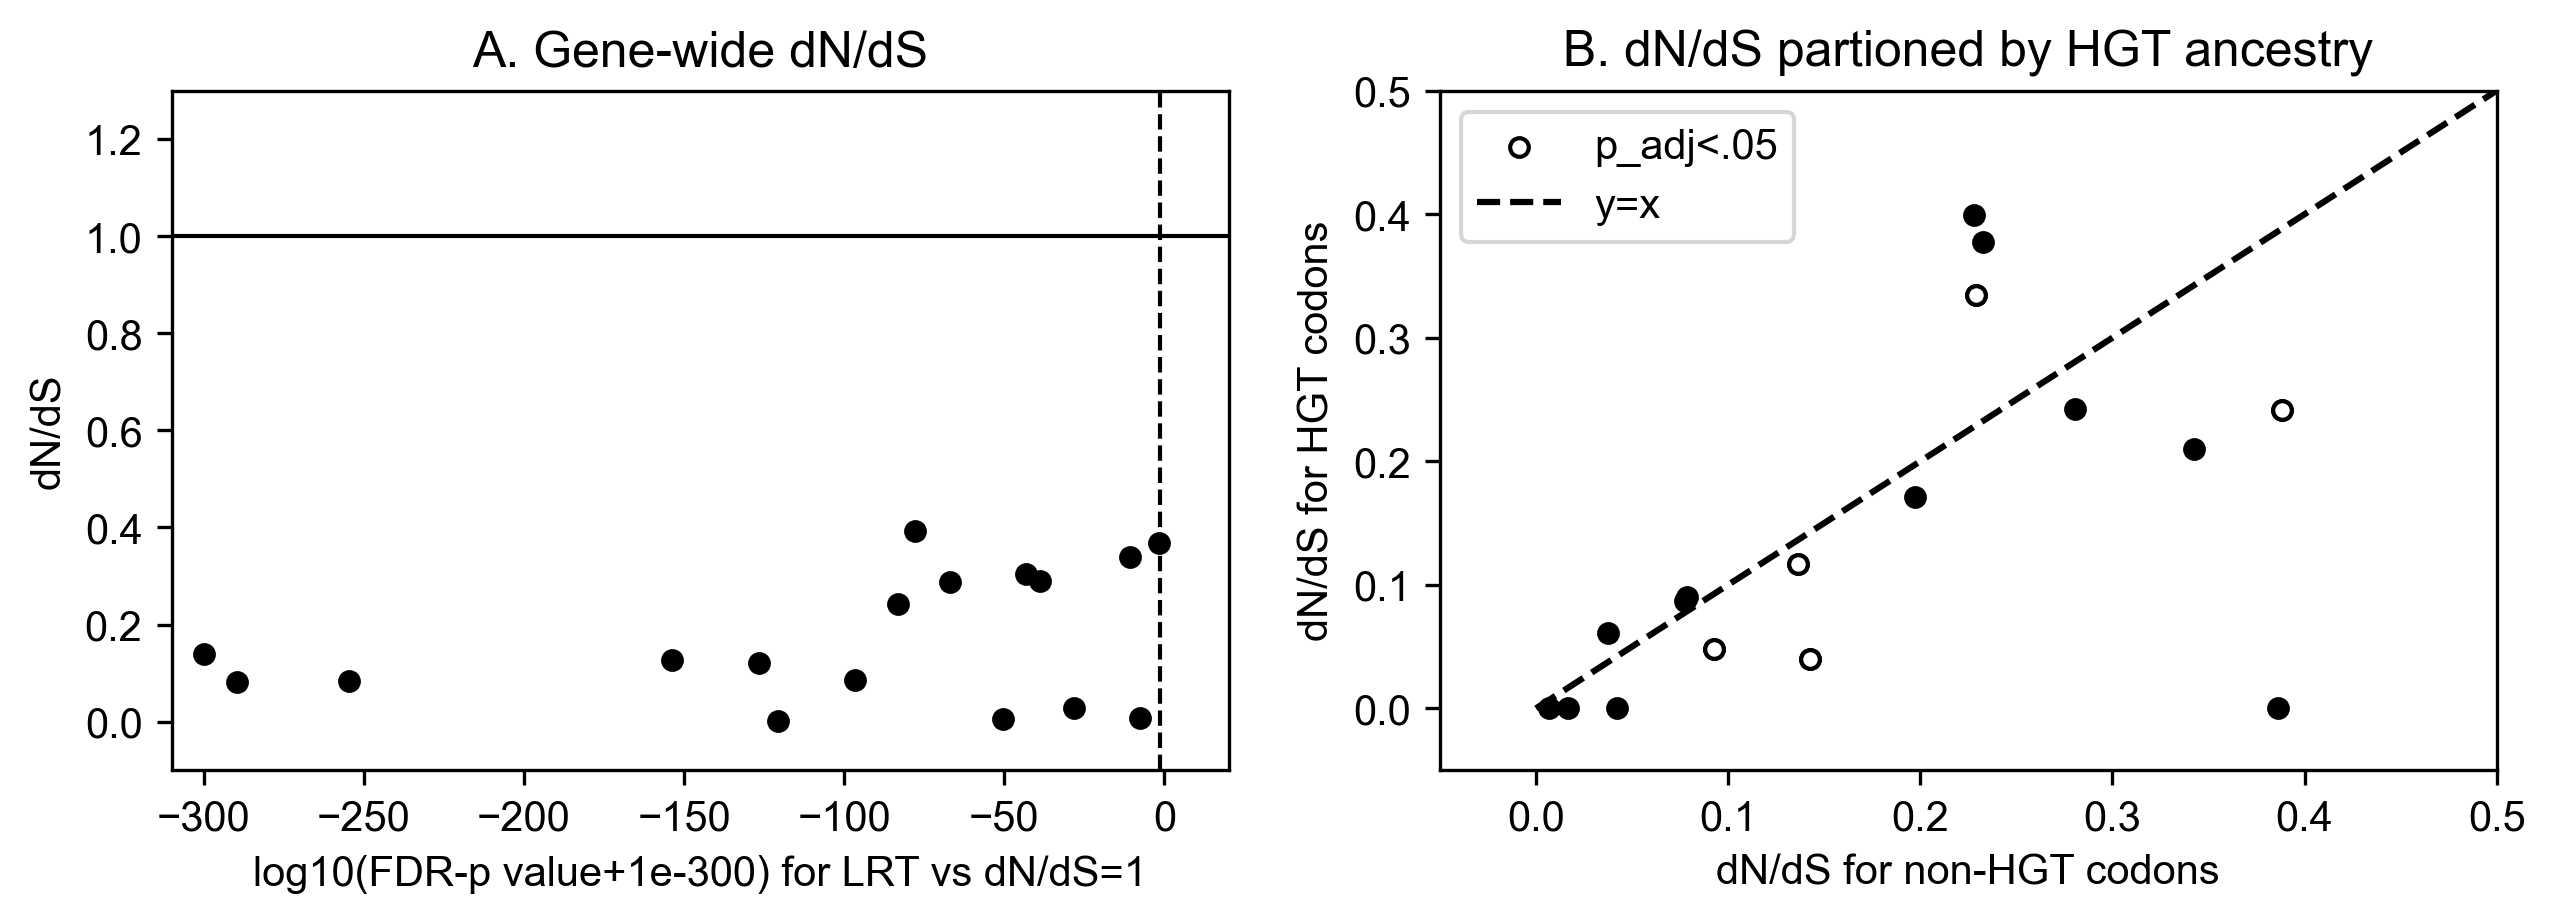

In [128]:
fig,ax=plt.subplots(1,2,dpi=300,figsize=(10,3))
ax[0].scatter(np.log10(dnds_data.p_val_corrected+1e-300),dnds_data.dnds_f,s=20,color='black')
ax[0].vlines(np.log10(.05),-.1,1.5,color='black',linestyle='dashed',label="p_adj=.05",linewidth=1)
ax[0].hlines(1,-320,20,color='black',linewidth=1)
ax[0].set_ylim(-.1,1.3)
ax[0].set_xlim(-310,20)
ax[0].set_title("A. Gene-wide dN/dS" )
ax[0].set_ylabel("dN/dS")
ax[0].set_xlabel("log10(FDR-p value+1e-300) for LRT vs dN/dS=1")


ax[1].scatter(pdnds.dnds_1,pdnds.dnds_2,color='black',s=20)
ax[1].scatter(pdnds[pdnds.correct_p_values < .05].dnds_1,
            pdnds[pdnds.correct_p_values < .05].dnds_2,
            color='white',
            edgecolor='black',  # Add black outline to points
            label="p_adj<.05",
            s=20)
ax[1].plot(np.linspace(0,.8,10),np.linspace(0,.8,10),label="y=x",color='black',linestyle='dashed')
ax[1].set_xlim(-0.05,.5)
ax[1].set_ylim(-.05,.5)
ax[1].legend()
ax[1].set_xlabel("dN/dS for non-HGT codons")
ax[1].set_ylabel("dN/dS for HGT codons")
ax[1].set_title("B. dN/dS partioned by HGT ancestry")


plt.savefig("combined_partition_dnds.svg",format='svg')
plt.show()